In [1]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
from tensorflow.keras.utils import plot_model
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import SGD

import tensorflow as tf
import pandas as pd
import numpy as np

In [2]:
BATCH_SIZE = 25
SIZE_TRAINSET = 0.8

## Model

In [34]:
#basis model
inputs = Input(shape=(3, 224, 224, 3), name='images')

ResNet = ResNet50(
    include_top=False,
    weights="imagenet",
    input_shape=(224, 224, 3)
)
ResNet.trainable = False

out1 = ResNet(inputs[:, 0])
out2 = ResNet(inputs[:, 1])
out3 = ResNet(inputs[:, 2])

basis1 = GlobalAveragePooling2D()(out1)
basis1 = Dropout(0.7)(basis1)
basis1 = Flatten()(basis1)

basis2 = GlobalAveragePooling2D()(out2)
basis2 = Dropout(0.7)(basis2)
basis2 = Flatten()(basis2)

basis3 = GlobalAveragePooling2D()(out3)
basis3 = Dropout(0.7)(basis3)
basis3 = Flatten()(basis3)


In [35]:
#own model
concat = Concatenate()([basis1, basis2, basis3])
#dense_1 = Dense(2048, activation='relu')(concat)
#dense_2 = Dense(1024, activation='relu')(dense_1)
dense_1 = Dense(10, activation='relu')(concat)
dense_2 = Dense(10, activation='relu')(dense_1)
output = Dense(1, activation='softmax')(dense_2)

my_model = Model(inputs = inputs, outputs=output)
my_model.summary()

Model: "model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
images (InputLayer)             [(None, 3, 224, 224, 0                                            
__________________________________________________________________________________________________
tf.__operators__.getitem_6 (Sli (None, 224, 224, 3)  0           images[0][0]                     
__________________________________________________________________________________________________
tf.__operators__.getitem_7 (Sli (None, 224, 224, 3)  0           images[0][0]                     
__________________________________________________________________________________________________
tf.__operators__.getitem_8 (Sli (None, 224, 224, 3)  0           images[0][0]                     
____________________________________________________________________________________________

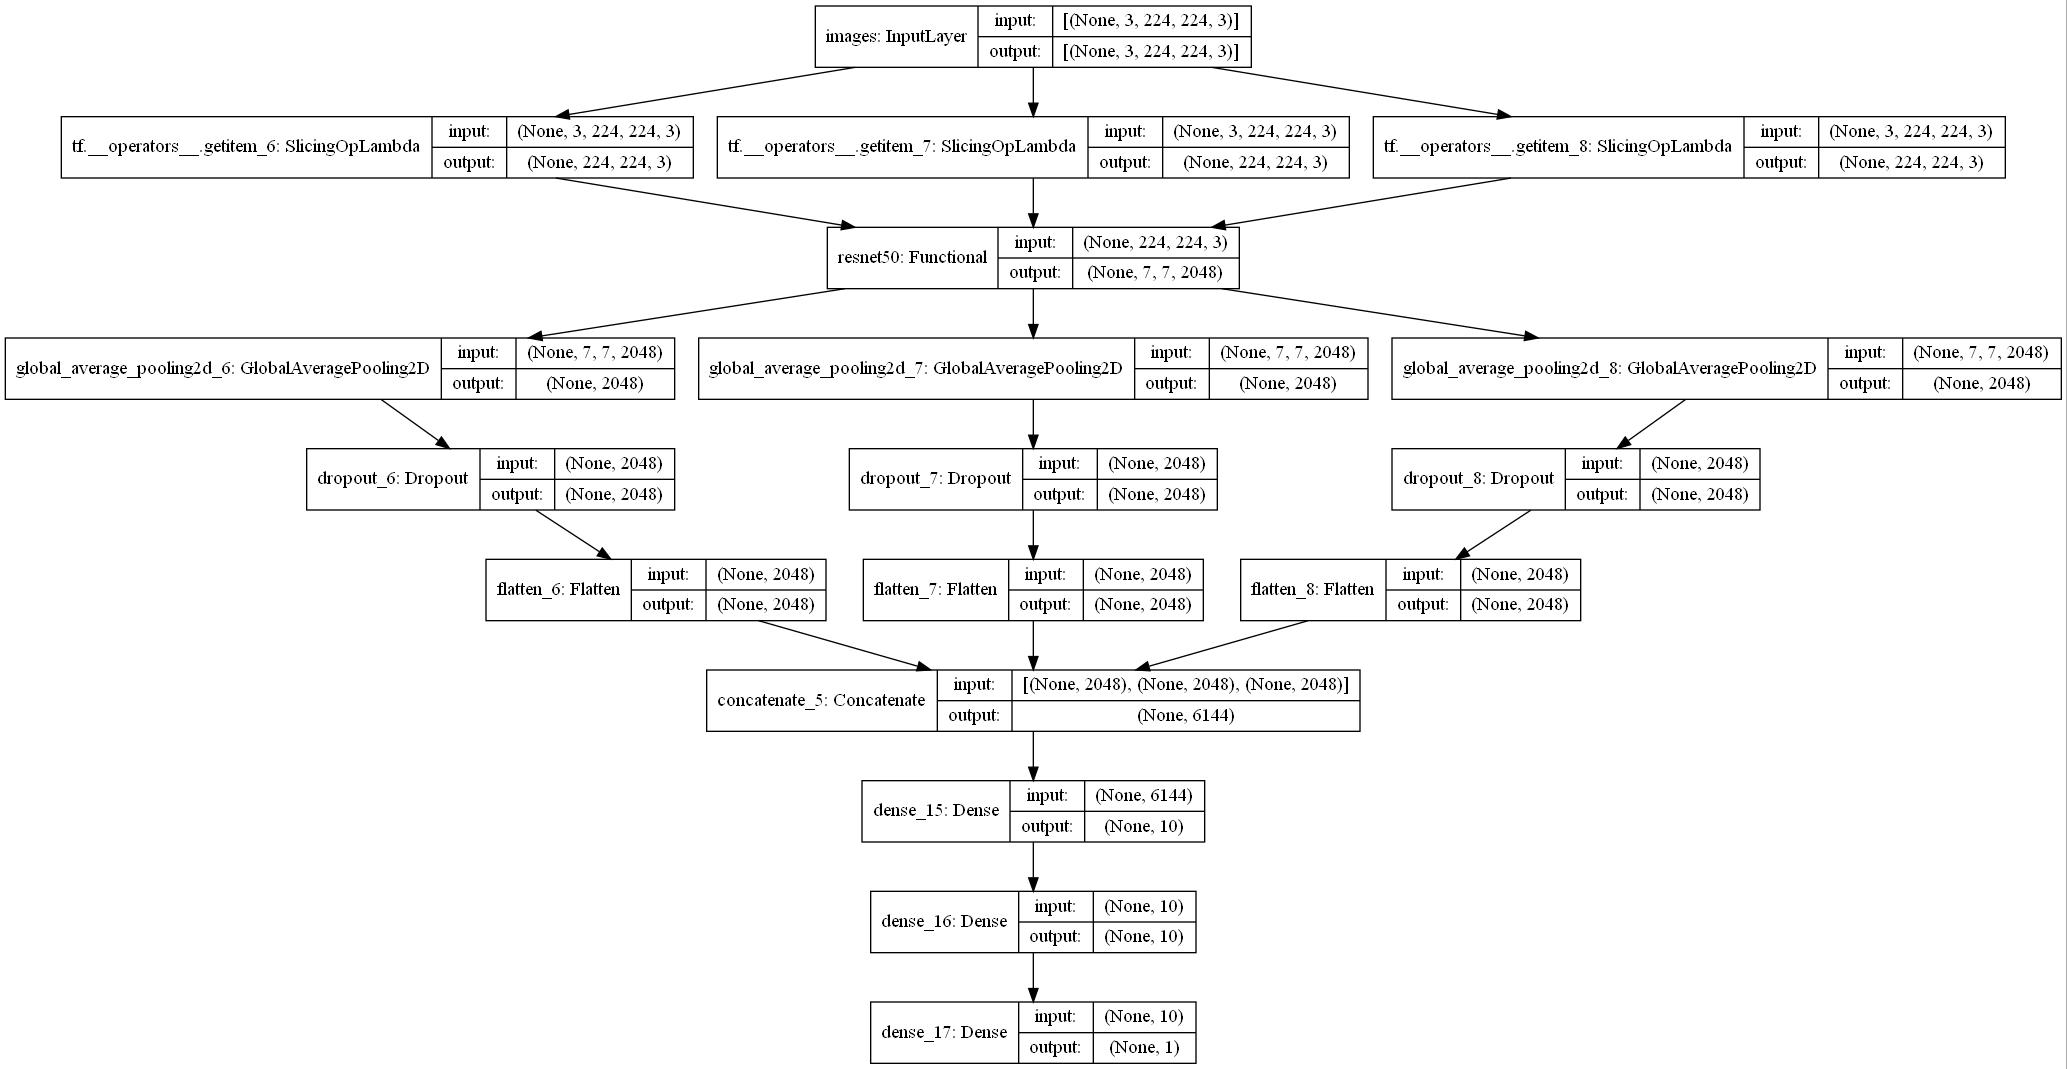

In [36]:
#may need to download required libraries


plot_model(my_model, show_shapes=True, to_file='my_model.jpg')
#plot_model(ResNet, show_shapes=True, to_file='ResNet50.jpg')

## Data

In [37]:
def shuffle_respectively(arr1, arr2):
    perm = np.random.permutation(arr1.shape[0])
    return arr1[perm], arr2[perm]


train_triplets_original = pd.read_csv('train_triplets.txt', sep=" ", dtype=str)
#train_triplets_original = "food/" + train_triplets_original + ".jpg"
train_triplets_original = train_triplets_original.to_numpy()[0:100]
np.random.shuffle(train_triplets_original)

# train_triplets is now:
# array([['/food/04923.jpg', '/food/03669.jpg', '/food/03352.jpg'],
#       ['/food/03154.jpg', '/food/00844.jpg', '/food/02221.jpg'],
#       ...,
#       ['/food/00941.jpg', '/food/01740.jpg', '/food/04769.jpg']],
#      dtype=object)


#### Divide into training and test set

train_set_size = (int)(len(train_triplets_original)*SIZE_TRAINSET)
valid_set_size = len(train_triplets_original)-train_set_size

train_set_X = train_triplets_original[0:train_set_size]
valid_set_X = train_triplets_original[train_set_size:]

train_set_Y = np.ones((train_set_size,1))
valid_set_Y = np.ones((valid_set_size,1))

#### change place of last two jpg paths in 50% and change Y at that location to 0
temp = np.empty((train_set_size,3),dtype='|S5')
for i in range((int)(train_set_size/2)):
    train_set_Y[i] = 0
    temp[i]=[train_set_X[i,0], train_set_X[i,2], train_set_X[i,1]]
for i in range((int)(train_set_size/2),train_set_size):
    temp[i]=train_set_X[i]
train_set_X = temp

temp = np.empty((valid_set_size,3),dtype='|S5')
for i in range((int)(valid_set_size/2)):
    valid_set_Y[i] = 0
    temp[i]=[valid_set_X[i,0], valid_set_X[i,2], valid_set_X[i,1]]
for i in range((int)(valid_set_size/2),valid_set_size):
    temp[i]=valid_set_X[i]
valid_set_X = temp
    
#### reshuffle while keeping respective indices
train_set_X, train_set_Y = shuffle_respectively(train_set_X, train_set_Y)
valid_set_X, valid_set_Y = shuffle_respectively(valid_set_X, valid_set_Y)

In [38]:
def image_loader(number):
    path = "food/" + number + ".jpg"
    file = tf.io.read_file(path)
    img = tf.image.decode_jpeg(file)
    img = tf.image.resize(images=img, size=[224,224])
    return preprocess_input(img)


#### load all images into memory since it't not too much.. right?
#images = np.empty(shape=(10000, 224, 224, 3), dtype=np.float32)
#images = tf.Tensor((10000, 224, 224, 3),dtype=np.float32)
#for i in range(10000):
  #  images[i] = image_loader("food/" + ("%05d"%i) + ".jpg")

#images = tf.convert_to_tensor(images, np.float32)

train_dataset = tf.data.Dataset.from_tensor_slices((train_set_X, train_set_Y))
valid_dataset = tf.data.Dataset.from_tensor_slices((valid_set_X, valid_set_Y))



In [39]:
def loading_triplets(triplet, label):
    inputs = ([image_loader(triplet[0]), image_loader(triplet[1]), image_loader(triplet[2])])
    return inputs, label

train_generator = train_dataset.map(loading_triplets).batch(BATCH_SIZE)
valid_generator = valid_dataset.map(loading_triplets).batch(BATCH_SIZE)

## Training

In [41]:
'''testX = np.stack([
    np.stack([images[0], images[1], images[2]], axis=0),
    np.stack([images[3], images[4], images[5]], axis=0),
    np.stack([images[6], images[7], images[8]], axis=0)
], axis=0)

#print(testX)

testY = np.stack([
    train_set_Y[0],
    train_set_Y[1],
    train_set_Y[2]
], axis=0)'''


my_model.compile(optimizer=SGD(learning_rate=0.001, momentum=0.9, nesterov=True), loss='binary_crossentropy', metrics=['accuracy'])
my_model.fit(train_generator, batch_size = BATCH_SIZE, epochs = 5, validation_data = valid_generator, verbose=2)
#my_model.fit(testX, y=testY, epochs = 5,  verbose=2)

Epoch 1/5
4/4 - 32s - loss: 0.6994 - accuracy: 0.5000 - val_loss: 0.6918 - val_accuracy: 0.5000
Epoch 2/5
4/4 - 21s - loss: 0.6959 - accuracy: 0.5000 - val_loss: 0.6925 - val_accuracy: 0.5000
Epoch 3/5
4/4 - 22s - loss: 0.7094 - accuracy: 0.5000 - val_loss: 0.6914 - val_accuracy: 0.5000
Epoch 4/5
4/4 - 24s - loss: 0.6905 - accuracy: 0.5000 - val_loss: 0.6908 - val_accuracy: 0.5000
Epoch 5/5
4/4 - 23s - loss: 0.6822 - accuracy: 0.5000 - val_loss: 0.6912 - val_accuracy: 0.5000


AttributeError: 'BatchDataset' object has no attribute 'next'

AttributeError: Can't set the attribute "name", likely because it conflicts with an existing read-only @property of the object. Please choose a different name.